<a href="https://colab.research.google.com/github/vivian-xia/Forecasting_SP500_Stock_Prices_with_LSTM/blob/main/Forecasting_S%26P_500_Stock_Prices_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Vivian Xia

# Forecasting S&P 500 Stock Prices with LSTM

## Import packages

In [1]:
pip install yfinance

In [2]:
import os
from datetime import datetime
from packaging import version
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Input, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [7]:
def plot_graphs():
  losses = history.history['loss']
  mae = history.history['mae']
  val_losses = history.history['val_loss']
  val_mae = history.history['val_mae']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, mae], [val_losses, val_mae], ['Loss', 'MAE'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
  plt.show()

In [8]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0] #value at i,i+1,i+2,..i+29
    dataX.append(a) #append list of values at those 30 steps each time used as inputs
    dataY.append(dataset[i + time_step, 0]) #append 30th value as predicted value 
  return np.array(dataX), np.array(dataY)

In [9]:
def input_sequence(dataset, input1, input2):
  # define input sequence
  in_seq1 = np.array(dataset[input1])
  in_seq2 = np.array(dataset[input2])
  out_seq = np.array(dataset[input1])

  # convert to [rows, columns] structure
  in_seq1 = in_seq1.reshape((len(in_seq1), 1))
  in_seq2 = in_seq2.reshape((len(in_seq2), 1))
  out_seq = out_seq.reshape((len(out_seq), 1))

  return in_seq1, in_seq2, out_seq

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

## Load Data

In [99]:
snp = "^GSPC" #S&P 500 symbol

# last five years
start_date = datetime(2017, 2, 28)
end_date = datetime(2022, 2, 28)

# get the data
df = yf.download(snp, start = start_date, end = end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-28,2366.080078,2367.790039,2358.959961,2363.639893,2363.639893,4210140000
2017-03-01,2380.129883,2400.979980,2380.129883,2395.959961,2395.959961,4345180000
2017-03-02,2394.750000,2394.750000,2380.169922,2381.919922,2381.919922,3821320000
2017-03-03,2380.919922,2383.889893,2375.389893,2383.120117,2383.120117,3555260000
2017-03-06,2375.229980,2378.800049,2367.979980,2375.310059,2375.310059,3232700000


In [100]:
df = df['Close']
df= pd.DataFrame(df)
df.head()

,Close
Date,
2017-02-28,2363.639893
2017-03-01,2395.959961
2017-03-02,2381.919922
2017-03-03,2383.120117
2017-03-06,2375.310059


## Explore Data

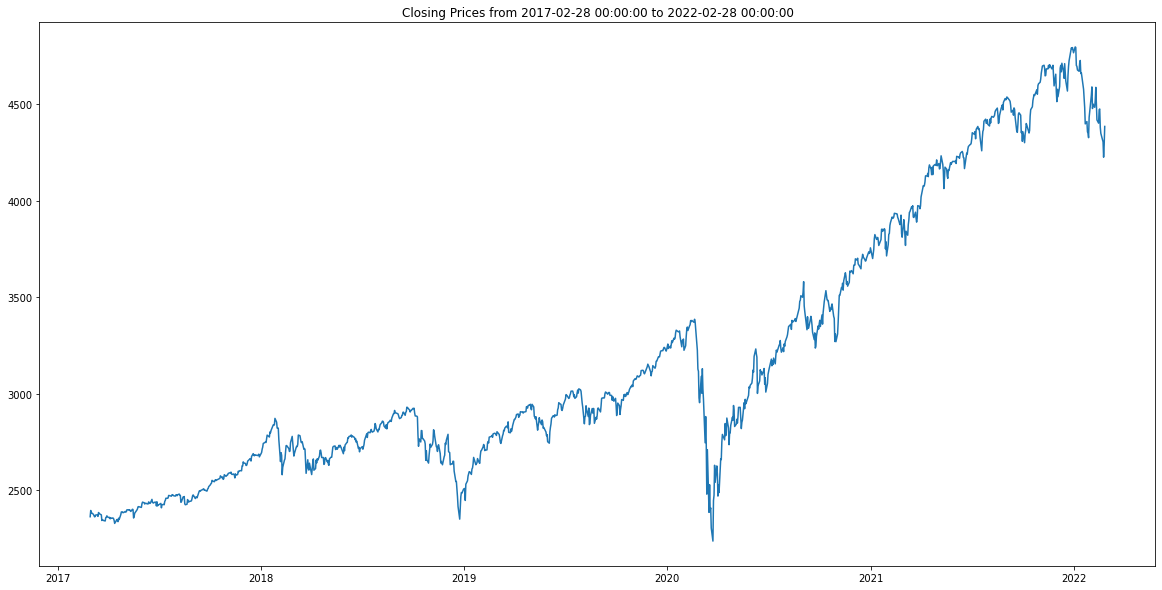

In [101]:
# display
plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(df['Close'])
plt.show()

[*********************100%***********************]  1 of 1 completed


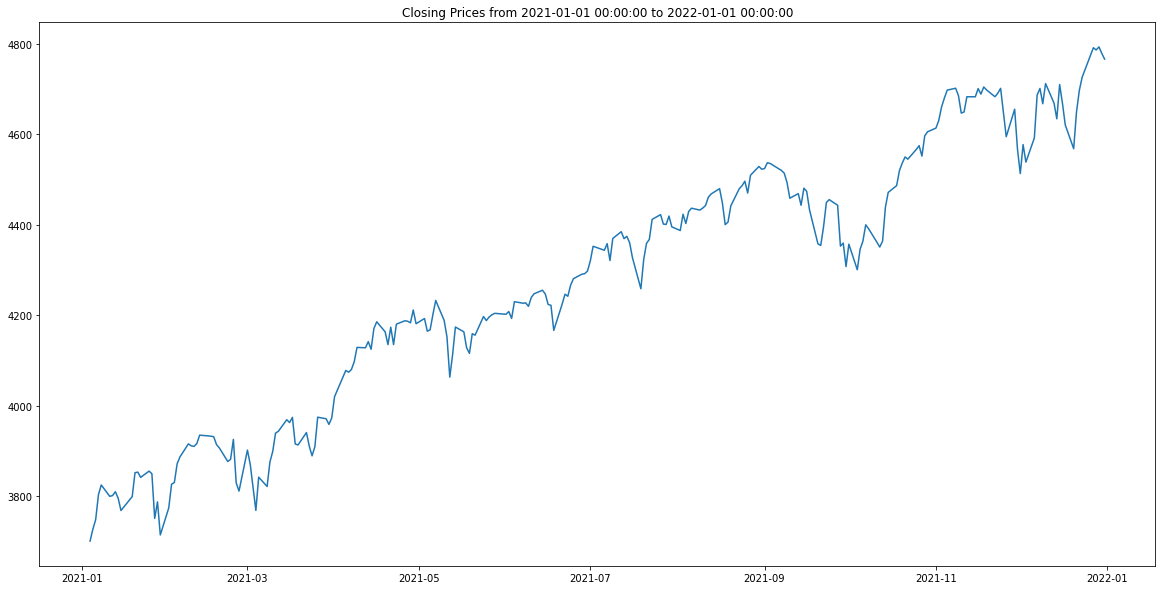

In [13]:
# last year
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1)

# get the data
data_oneyear = yf.download(snp, start = start_date, end = end_date)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(data_oneyear['Close'])
plt.show()

In [102]:
df.describe()

,Close
count,1259.000000
mean,3187.588139
std,688.889599
min,2237.399902
25%,2690.989990
50%,2918.649902
75%,3628.279907
max,4796.560059


#Experiment A: Input - Closing Price, Time step - 30

## Preprocess Data

In [103]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [104]:
data.shape

(1259, 1)

In [105]:
# split into train, val, and test sets
train_size = int(len(data) * 0.70)
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

In [106]:
train_data,val_data, test_data = data[0:train_size,:], data[train_size:train_size+val_size,:], data[train_size+val_size:len(data),:]
train_data.shape, val_data.shape, test_data.shape

((881, 1), (188, 1), (190, 1))

In [107]:
#reshape into X=t,t+1,...,t+29 and Y=t+30 -- 30 time steps to use as input variables to predict the next time period
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [108]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (850, 30, 1)
validation set:  (157, 30, 1)
test set:  (159, 30, 1)


## Experiment A.1

### Create the model

In [34]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(30, 1))) 
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1760      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [37]:
experiment = "ExperimentA1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [38]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 4s 45ms/step - loss: 0.0131 - mae: 0.0878 - val_loss: 0.0252 - val_mae: 0.1534
Epoch 2/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0055 - mae: 0.0551 - val_loss: 0.0135 - val_mae: 0.1120
Epoch 3/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0045 - mae: 0.0505 - val_loss: 0.0077 - val_mae: 0.0843
Epoch 4/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0038 - mae: 0.0470 - val_loss: 0.0034 - val_mae: 0.0547
Epoch 5/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0037 - mae: 0.0451 - val_loss: 0.0038 - val_mae: 0.0581
Epoch 6/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0029 - mae: 0.0402 - val_loss: 0.0028 - val_mae: 0.0488
Epoch 7/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0030 - mae: 0.0405 - val_loss: 0.0030 - val_mae: 0.0507
Epoch 8/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0024 - m

In [109]:
experiment = "ExperimentA1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [76]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 1s 7ms/step - loss: 9.1761e-04 - mae: 0.0255
test set mae:  0.025463251397013664


### Plot performance

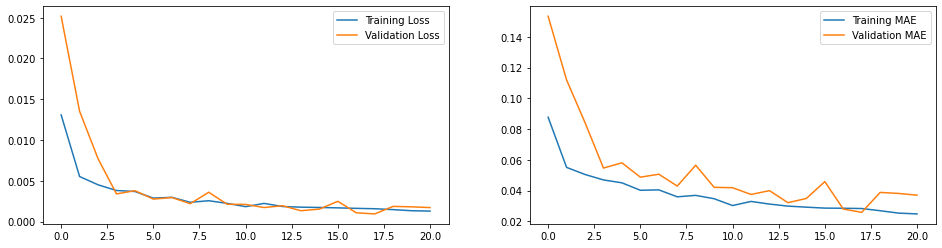

In [41]:
plot_graphs()

In [110]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

In [111]:
vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [112]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [113]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

In [114]:
vis_df_a1 = pd.concat([a,b,c], axis=1)
vis_df_a1.head()

,Date,Actual,Predicted
0,2021-07-12,4384.629883,4304.784180
1,2021-07-13,4369.209961,4317.341309
2,2021-07-14,4374.299805,4324.958984
3,2021-07-15,4360.029785,4331.839355
4,2021-07-16,4327.160156,4334.152344


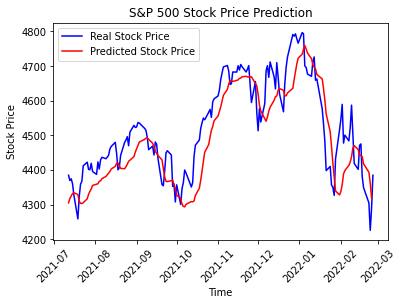

In [115]:
# plot baseline and predictions
plt.plot(vis_df_a1['Date'], vis_df_a1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment A.2

### Create the model

In [48]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(30, 1), return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 30)            3840      
                                                                 
 dropout_2 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [51]:
experiment = "ExperimentA2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [52]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 7s 76ms/step - loss: 0.0262 - mae: 0.1277 - val_loss: 0.0676 - val_mae: 0.2533
Epoch 2/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0057 - mae: 0.0600 - val_loss: 0.0258 - val_mae: 0.1560
Epoch 3/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0043 - mae: 0.0483 - val_loss: 0.0046 - val_mae: 0.0637
Epoch 4/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0038 - mae: 0.0457 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 5/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0036 - mae: 0.0422 - val_loss: 0.0023 - val_mae: 0.0431
Epoch 6/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0031 - mae: 0.0407 - val_loss: 0.0046 - val_mae: 0.0636
Epoch 7/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0029 - mae: 0.0389 - val_loss: 0.0020 - val_mae: 0.0403
CPU times: user 14.7 s, sys: 702 ms, total: 15.4 s
Wall time: 12.1 s


In [116]:
experiment = "ExperimentA2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [54]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 2s 11ms/step - loss: 0.0014 - mae: 0.0280
test set mae:  0.027953490614891052


### Plot performance

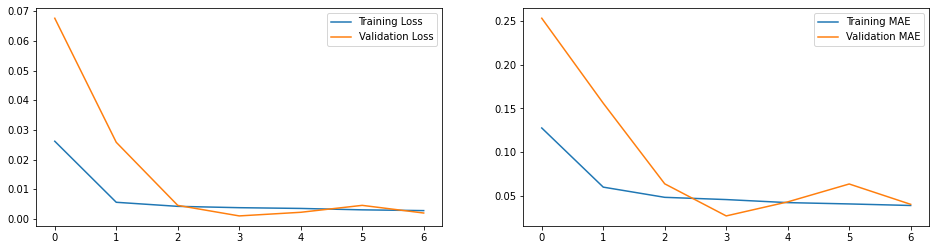

In [55]:
plot_graphs()

In [117]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [118]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [119]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_a2 = pd.concat([a,b,c], axis=1)

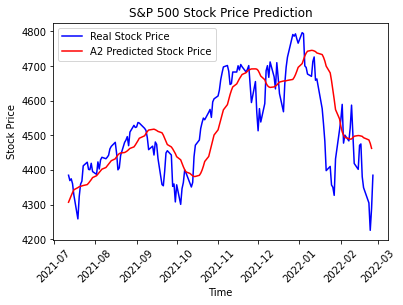

In [120]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

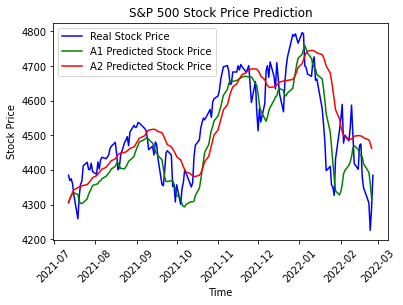

In [87]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment A.3

### Create the model

In [89]:
model = models.Sequential()
model.add(LSTM(40, input_shape=(30, 1), return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(40))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 40)            6720      
                                                                 
 dropout_4 (Dropout)         (None, 30, 40)            0         
                                                                 
 lstm_5 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 41        
                                                                 
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [91]:
experiment = "ExperimentA3"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [93]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 11s 203ms/step - loss: 0.0182 - mae: 0.1028 - val_loss: 0.0669 - val_mae: 0.2534
Epoch 2/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0051 - mae: 0.0540 - val_loss: 0.0147 - val_mae: 0.1174
Epoch 3/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0037 - mae: 0.0443 - val_loss: 7.1587e-04 - val_mae: 0.0211
Epoch 4/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0034 - mae: 0.0423 - val_loss: 0.0025 - val_mae: 0.0459
Epoch 5/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0029 - mae: 0.0395 - val_loss: 0.0046 - val_mae: 0.0643
Epoch 6/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0026 - mae: 0.0387 - val_loss: 0.0015 - val_mae: 0.0344
CPU times: user 15.7 s, sys: 456 ms, total: 16.1 s
Wall time: 16 s


In [121]:
experiment = "ExperimentA3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [95]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 1s 10ms/step - loss: 0.0017 - mae: 0.0296
test set mae:  0.029640713706612587


### Plot performance

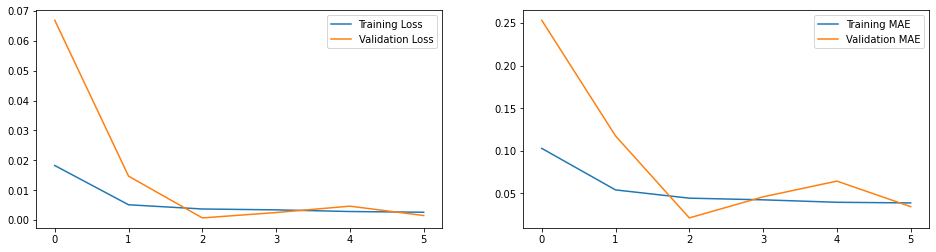

In [96]:
plot_graphs()

In [122]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [123]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [124]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_a3 = pd.concat([a,b,c], axis=1)

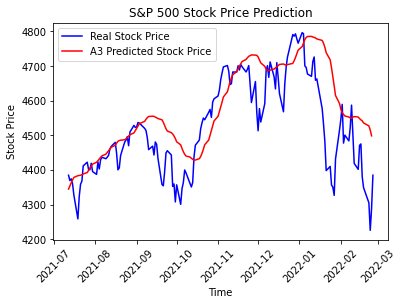

In [125]:
# plot baseline and predictions
plt.plot(vis_df_a3['Date'], vis_df_a3['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'red', label = 'A3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

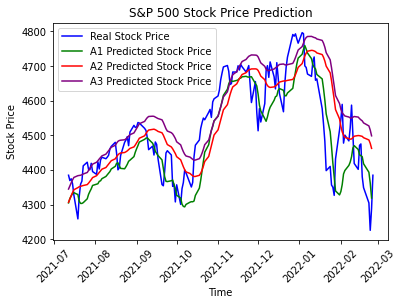

In [101]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'purple', label = 'A3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment A.4

### Create the model

In [197]:
model = models.Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(30,1)))
model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [198]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 30, 40)           3520      
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 30, 40)            0         
                                                                 
 lstm_27 (LSTM)              (None, 20)                4880      
                                                                 
 dropout_27 (Dropout)        (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 8,421
Trainable params: 8,421
Non-trainable params: 0
___________________________________________________

In [199]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [200]:
experiment = "ExperimentA4"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [201]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 9s 100ms/step - loss: 0.0144 - mae: 0.0924 - val_loss: 0.0681 - val_mae: 0.2545
Epoch 2/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0064 - mae: 0.0602 - val_loss: 0.0297 - val_mae: 0.1670
Epoch 3/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0050 - mae: 0.0528 - val_loss: 0.0106 - val_mae: 0.0983
Epoch 4/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0044 - mae: 0.0491 - val_loss: 0.0058 - val_mae: 0.0720
Epoch 5/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0039 - mae: 0.0460 - val_loss: 0.0048 - val_mae: 0.0651
Epoch 6/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0034 - mae: 0.0430 - val_loss: 0.0086 - val_mae: 0.0886
Epoch 7/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0031 - mae: 0.0407 - val_loss: 0.0026 - val_mae: 0.0470
Epoch 8/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0029 - 

In [126]:
experiment = "ExperimentA4"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [203]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 1s 11ms/step - loss: 0.0069 - mae: 0.0772
test set mae:  0.07721106708049774


### Plot performance

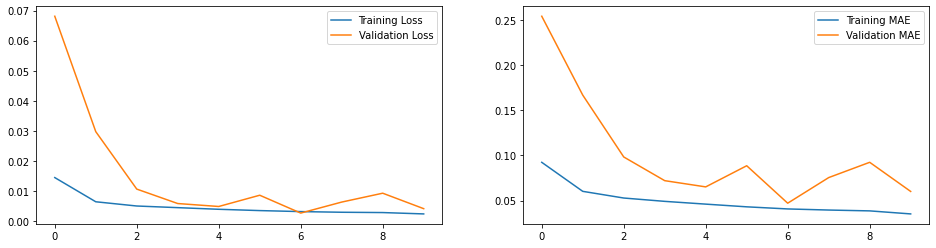

In [204]:
plot_graphs()

In [127]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [128]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [129]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_a4 = pd.concat([a,b,c], axis=1)

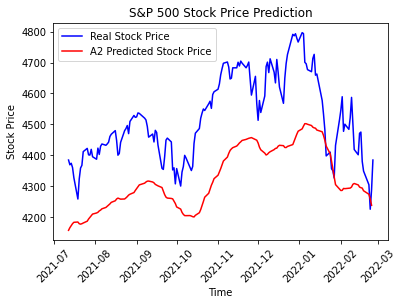

In [208]:
# plot baseline and predictions
plt.plot(vis_df_a4['Date'], vis_df_a4['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a4['Date'], vis_df_a4['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

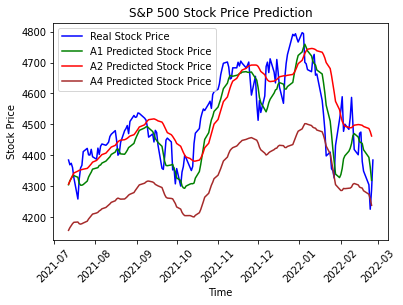

In [209]:
# plot baseline and predictions
plt.plot(vis_df_a4['Date'], vis_df_a4['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')
#plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'purple', label = 'A3 Predicted Stock Price')
plt.plot(vis_df_a4['Date'], vis_df_a4['Predicted'], color = 'brown', label = 'A4 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Experiment B: Input - Closing Price, Time step - 15

## Preprocess Data

In [130]:
#reshape into X=t,t+1,...,t+14 and Y=t+15 -- 15 time steps to use as input variables to predict the next time period
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [131]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (865, 15, 1)
validation set:  (172, 15, 1)
test set:  (174, 15, 1)


## Experiment B.1

### Create the model

In [212]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(15, 1))) 
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [213]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20)                1760      
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [214]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [215]:
experiment = "ExperimentB1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [216]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 3s 39ms/step - loss: 0.0151 - mae: 0.0943 - val_loss: 0.0341 - val_mae: 0.1749
Epoch 2/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0069 - mae: 0.0625 - val_loss: 0.0279 - val_mae: 0.1591
Epoch 3/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0048 - mae: 0.0509 - val_loss: 0.0120 - val_mae: 0.1022
Epoch 4/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0086 - val_mae: 0.0871
Epoch 5/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0039 - mae: 0.0451 - val_loss: 0.0067 - val_mae: 0.0769
Epoch 6/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0033 - mae: 0.0411 - val_loss: 0.0019 - val_mae: 0.0388
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0019 - val_mae: 0.0395
Epoch 8/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0030 - m

In [132]:
experiment = "ExperimentB1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [218]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

6/6 [==============================] - 1s 4ms/step - loss: 0.0052 - mae: 0.0661
test set mae:  0.0660882517695427


### Plot performance

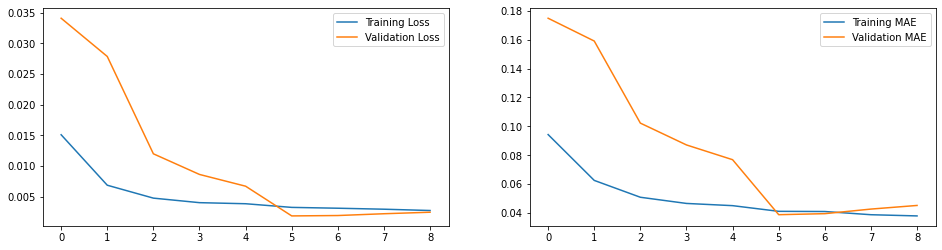

In [219]:
plot_graphs()

In [133]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

In [134]:
vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [135]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [136]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b1 = pd.concat([a,b,c], axis=1)

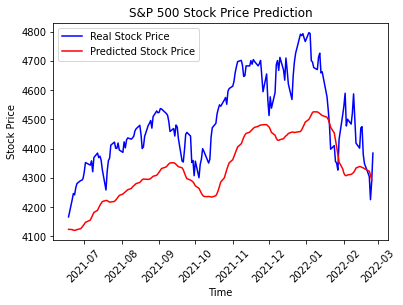

In [225]:
# plot baseline and predictions
plt.plot(vis_df_b1['Date'], vis_df_b1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

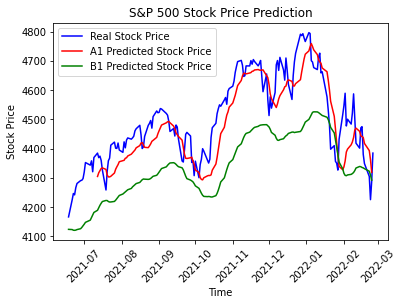

In [246]:
plt.plot(vis_df_b1['Date'], vis_df_b1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment B.2

### Create the model

In [233]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(15, 1), return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [234]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 15, 20)            1760      
                                                                 
 dropout_31 (Dropout)        (None, 15, 20)            0         
                                                                 
 lstm_32 (LSTM)              (None, 20)                3280      
                                                                 
 dropout_32 (Dropout)        (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [235]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [236]:
experiment = "ExperimentB2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [237]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 7s 60ms/step - loss: 0.0207 - mae: 0.1155 - val_loss: 0.0700 - val_mae: 0.2551
Epoch 2/50
28/28 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0682 - val_loss: 0.0267 - val_mae: 0.1559
Epoch 3/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0053 - mae: 0.0558 - val_loss: 0.0078 - val_mae: 0.0831
Epoch 4/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0045 - mae: 0.0499 - val_loss: 0.0080 - val_mae: 0.0849
Epoch 5/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0041 - mae: 0.0480 - val_loss: 0.0033 - val_mae: 0.0525
Epoch 6/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0035 - mae: 0.0430 - val_loss: 0.0016 - val_mae: 0.0343
Epoch 7/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0035 - mae: 0.0423 - val_loss: 0.0013 - val_mae: 0.0300
Epoch 8/50
28/28 [==============================] - 1s 19ms/step - loss: 0.0032 - m

In [137]:
experiment = "ExperimentB2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [239]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

6/6 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0282
test set mae:  0.028219468891620636


### Plot performance

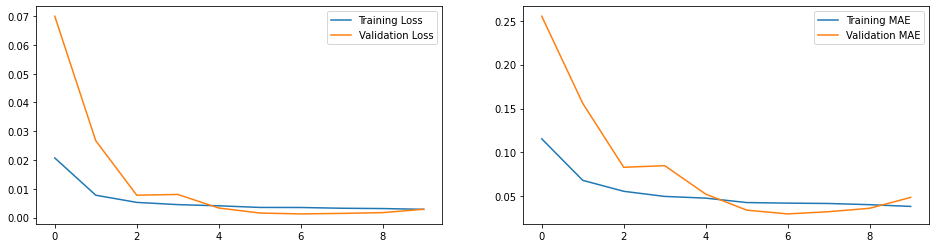

In [240]:
plot_graphs()

In [138]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [139]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [140]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b2 = pd.concat([a,b,c], axis=1)

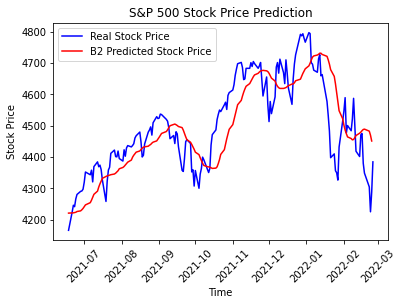

In [244]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'red', label = 'B2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

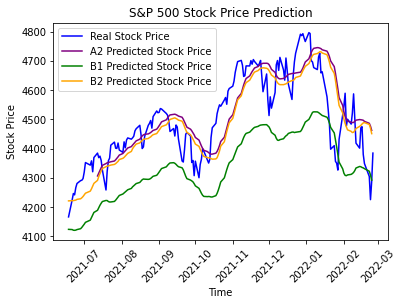

In [257]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
#plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment B.3

### Create the model

In [258]:
model = models.Sequential()
model.add(LSTM(40, input_shape=(15, 1), return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(40))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [259]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 15, 40)            6720      
                                                                 
 dropout_33 (Dropout)        (None, 15, 40)            0         
                                                                 
 lstm_34 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_34 (Dropout)        (None, 40)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 41        
                                                                 
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [260]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [261]:
experiment = "ExperimentB3"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [262]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 7s 59ms/step - loss: 0.0116 - mae: 0.0814 - val_loss: 0.0453 - val_mae: 0.2064
Epoch 2/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0041 - mae: 0.0494 - val_loss: 0.0088 - val_mae: 0.0884
Epoch 3/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0029 - mae: 0.0394 - val_loss: 0.0015 - val_mae: 0.0337
Epoch 4/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0026 - mae: 0.0375 - val_loss: 0.0022 - val_mae: 0.0425
Epoch 5/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0024 - mae: 0.0364 - val_loss: 0.0027 - val_mae: 0.0477
Epoch 6/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0024 - mae: 0.0354 - val_loss: 0.0011 - val_mae: 0.0281
Epoch 7/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0023 - mae: 0.0357 - val_loss: 0.0043 - val_mae: 0.0614
Epoch 8/50
28/28 [==============================] - 1s 21ms/step - loss: 0.0021 - m

In [141]:
experiment = "ExperimentB3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [264]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

6/6 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0257
test set mae:  0.025731395930051804


### Plot performance

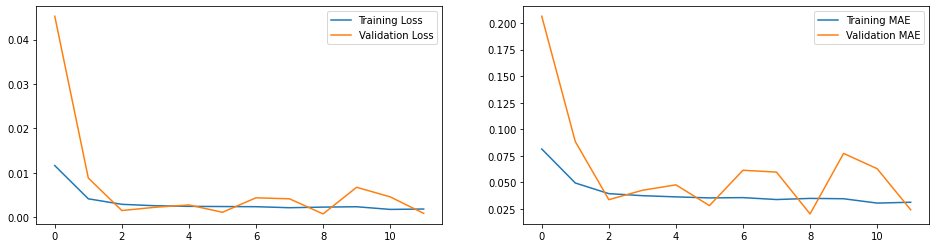

In [265]:
plot_graphs()

In [142]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [143]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [144]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b3 = pd.concat([a,b,c], axis=1)

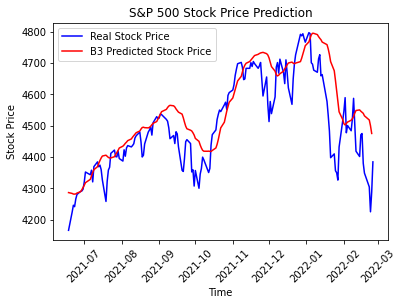

In [269]:
# plot baseline and predictions
plt.plot(vis_df_b3['Date'], vis_df_b3['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'red', label = 'B3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

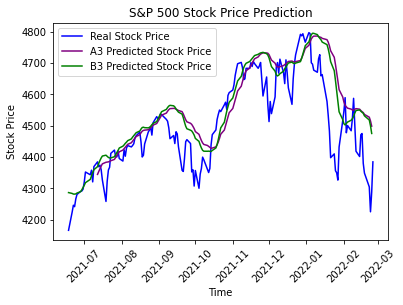

In [275]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'purple', label = 'A3 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'green', label = 'B3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

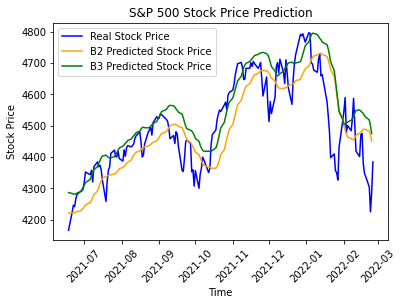

In [277]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'green', label = 'B3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

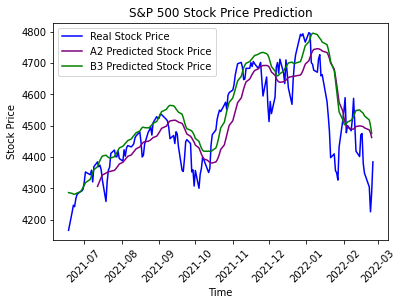

In [278]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
#plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'green', label = 'B3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

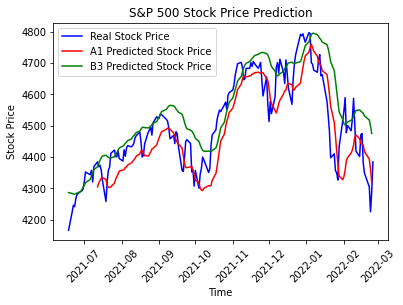

In [279]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'green', label = 'B3 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Experiment C: Input - Closing Price and New Probable Cases, Time Step - 30

Multivariate Forecasting

### Load Data

Covid-19 cases: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36

In [146]:
os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/')
path_to_file='United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv'
covid_df = pd.read_csv(path_to_file)

covid_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/11/2021,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN
1,02/12/2021,UT,359641,359641.0,0.0,1060,0.0,1785,1729.0,56.0,11,2.0,02/13/2021 02:50:08 PM,Agree,Agree
2,03/01/2021,CO,438745,411869.0,26876.0,677,60.0,5952,5218.0,734.0,1,0.0,03/01/2021 12:00:00 AM,Agree,Agree
3,02/04/2020,AR,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
4,08/22/2020,AR,56199,NaN,NaN,547,0.0,674,NaN,NaN,11,0.0,08/23/2020 02:15:28 PM,Not agree,Not agree


In [147]:
covid_df = covid_df[['submission_date','new_case','pnew_case']]
covid_df = covid_df.groupby('submission_date').sum().reset_index().sort_values(by='submission_date')

print(covid_df.head())
print(covid_df.info())

  submission_date  new_case  pnew_case
0      01/01/2021    227801    26295.0
1      01/01/2022    288614    36296.0
2      01/02/2021    226839    19715.0
3      01/02/2022    409050    59688.0
4      01/03/2021    205089    19598.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 770
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   submission_date  771 non-null    object 
 1   new_case         771 non-null    int64  
 2   pnew_case        771 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.1+ KB
None


In [148]:
covid_df['submission_date'] = covid_df['submission_date'].astype('datetime64')
covid_df.head()

,submission_date,new_case,pnew_case
0,2021-01-01,227801,26295.0
1,2022-01-01,288614,36296.0
2,2021-01-02,226839,19715.0
3,2022-01-02,409050,59688.0
4,2021-01-03,205089,19598.0


In [150]:
df = df.reset_index()
df.head()

,Date,Close
0,2017-02-28,2363.639893
1,2017-03-01,2395.959961
2,2017-03-02,2381.919922
3,2017-03-03,2383.120117
4,2017-03-06,2375.310059


In [151]:
merge_df = pd.merge(df, covid_df, left_on = 'Date', right_on = 'submission_date', how = 'left')
merge_df.head()

,Date,Close,submission_date,new_case,pnew_case
0,2017-02-28,2363.639893,NaT,NaN,NaN
1,2017-03-01,2395.959961,NaT,NaN,NaN
2,2017-03-02,2381.919922,NaT,NaN,NaN
3,2017-03-03,2383.120117,NaT,NaN,NaN
4,2017-03-06,2375.310059,NaT,NaN,NaN


In [152]:
merge_df.isnull().sum()

Date                 0
Close                0
submission_date    729
new_case           729
pnew_case          729
dtype: int64

The NaT in submission_date and tot_cases are accounting for when Covid-19 had 0 cases. There were 729 days of stock price data with no covid cases.

In [153]:
merge_df = merge_df.fillna(0)
merge_df.head()

,Date,Close,submission_date,new_case,pnew_case
0,2017-02-28,2363.639893,0,0.0,0.0
1,2017-03-01,2395.959961,0,0.0,0.0
2,2017-03-02,2381.919922,0,0.0,0.0
3,2017-03-03,2383.120117,0,0.0,0.0
4,2017-03-06,2375.310059,0,0.0,0.0


In [154]:
merge_df.isnull().sum()

Date               0
Close              0
submission_date    0
new_case           0
pnew_case          0
dtype: int64

In [155]:
merge_df = merge_df.drop(['submission_date'], axis=1)
merge_df.head()

,Date,Close,new_case,pnew_case
0,2017-02-28,2363.639893,0.0,0.0
1,2017-03-01,2395.959961,0.0,0.0
2,2017-03-02,2381.919922,0.0,0.0
3,2017-03-03,2383.120117,0.0,0.0
4,2017-03-06,2375.310059,0.0,0.0


### Explore Data

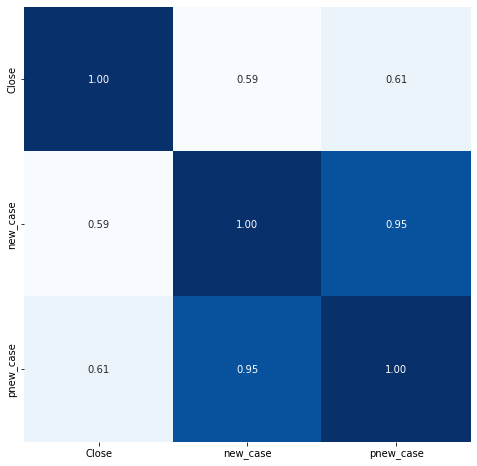

In [156]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(merge_df.corr(), annot=True, fmt='.2f', cbar=False, ax=ax, cmap='Blues')

Looking at the first row of the matrix, the closing stock prices have the most correlation with probable new cases than new cases. 

In [157]:
merge_df = merge_df[['Date','Close','pnew_case']]

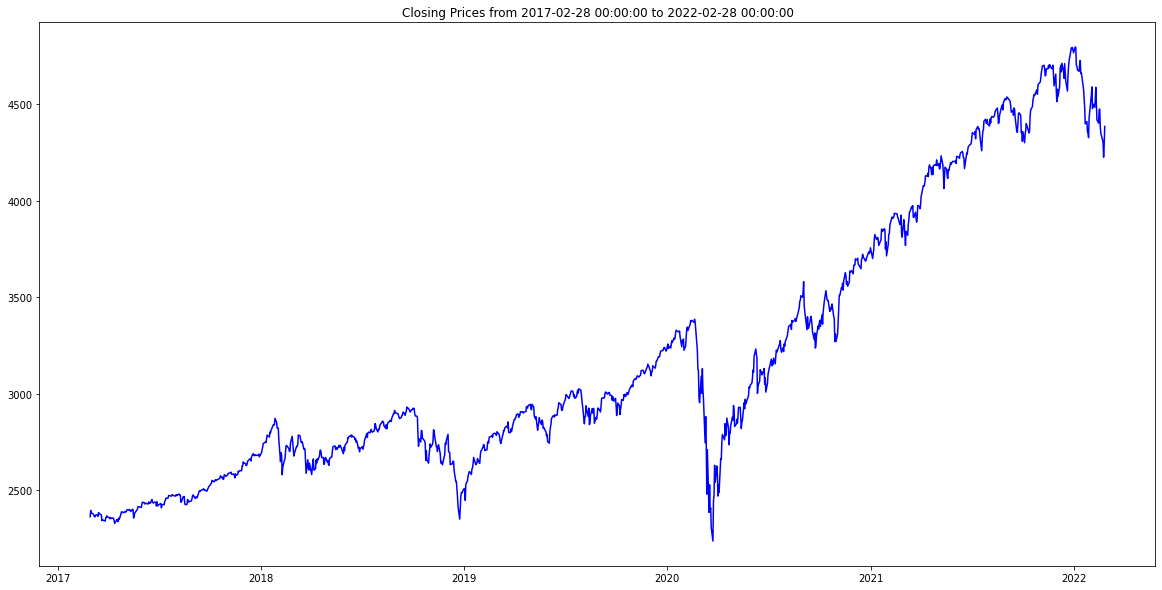

In [158]:
# last five years
start_date = datetime(2017, 2, 28)
end_date = datetime(2022, 2, 28)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(merge_df.Date, merge_df['Close'], color = 'blue')
#plt.plot(merge_df.Date, merge_df['pnew_case'], color = 'orange')
plt.show()

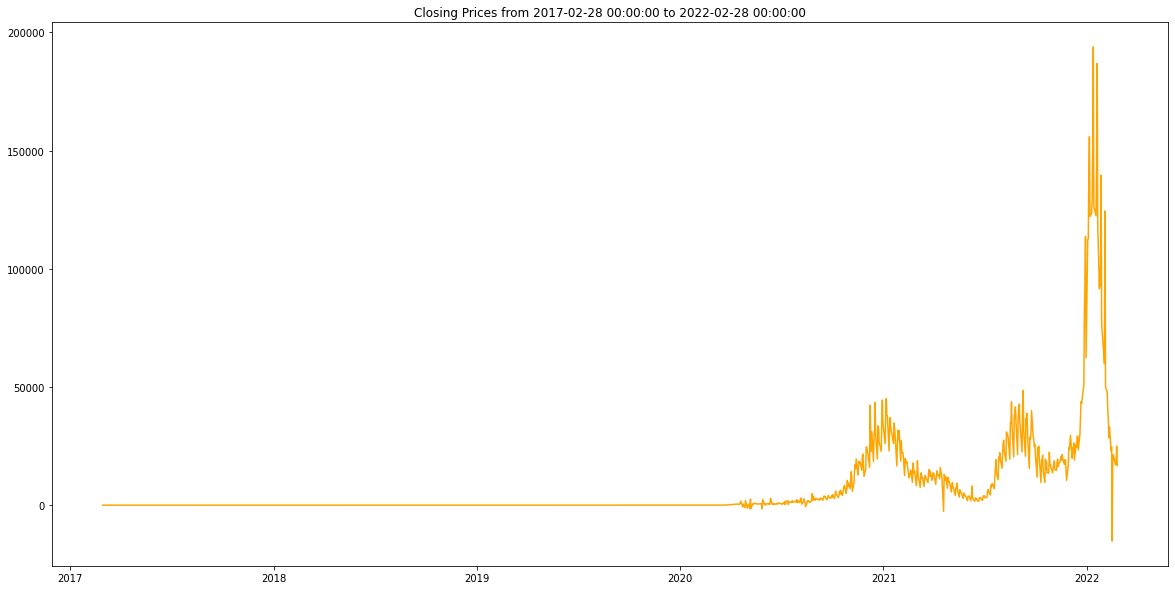

In [469]:
# last five years
start_date = datetime(2017, 2, 28)
end_date = datetime(2022, 2, 28)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
#plt.plot(merge_df.Date, merge_df['Close'], color = 'blue')
plt.plot(merge_df.Date, merge_df['pnew_case'], color = 'orange')
plt.show()

### Preprocess Data

In [159]:
merge_df.set_index(keys='Date')

,Close,pnew_case
Date,,
2017-02-28,2363.639893,0.0
2017-03-01,2395.959961,0.0
2017-03-02,2381.919922,0.0
2017-03-03,2383.120117,0.0
2017-03-06,2375.310059,0.0
...,...,...
2022-02-18,4348.870117,21477.0
2022-02-22,4304.759766,17049.0
2022-02-23,4225.500000,17342.0


In [160]:
close_scaler = MinMaxScaler(feature_range=(0,1))
case_scaler = MinMaxScaler(feature_range=(0,1))
merge_data = merge_df.copy()
merge_data["Close"] = close_scaler.fit_transform(np.array(merge_df["Close"]).reshape(-1, 1))
merge_data["pnew_case"] = case_scaler.fit_transform(np.array(merge_df["pnew_case"]).reshape(-1, 1))

In [161]:
merge_data.shape

(1259, 3)

In [162]:
# split into train, val, and test sets
train_size = int(len(merge_data) * 0.70)
val_size = int(0.15 * len(merge_data))
test_size = len(merge_data) - train_size - val_size

In [163]:
train_size, val_size, test_size

(881, 188, 190)

In [164]:
train_data,val_data, test_data = merge_data[0:train_size], merge_data[train_size:train_size+val_size], merge_data[train_size+val_size:len(merge_data)]

In [165]:
train_data.shape, val_data.shape, test_data.shape

((881, 3), (188, 3), (190, 3))

In [166]:
# choose a number of time steps
time_step = 30
input1 = "Close"
input2 = "pnew_case"

in_seq1, in_seq2, out_seq = input_sequence(train_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_train, y_train = split_sequences(dataset, time_step)
print(X_train.shape, X_train.shape)
for i in range(len(X_train)):
  print(X_train[i], y_train[i])
  break

(851, 30, 2) (851, 30, 2)
[[0.049 0.073]
 [0.062 0.073]
 [0.056 0.073]
 [0.057 0.073]
 [0.054 0.073]
 [0.051 0.073]
 [0.049 0.073]
 [0.05  0.073]
 [0.053 0.073]
 [0.053 0.073]
 [0.05  0.073]
 [0.058 0.073]
 [0.056 0.073]
 [0.055 0.073]
 [0.053 0.073]
 [0.042 0.073]
 [0.043 0.073]
 [0.042 0.073]
 [0.042 0.073]
 [0.041 0.073]
 [0.047 0.073]
 [0.048 0.073]
 [0.051 0.073]
 [0.049 0.073]
 [0.047 0.073]
 [0.048 0.073]
 [0.045 0.073]
 [0.047 0.073]
 [0.046 0.073]
 [0.047 0.073]] 0.045475906097123486


In [167]:
in_seq1, in_seq2, out_seq = input_sequence(val_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_val, y_val = split_sequences(dataset, time_step)

In [168]:
in_seq1, in_seq2, out_seq = input_sequence(test_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_test, y_test = split_sequences(dataset, time_step)

In [169]:
X_train.shape, X_val.shape, X_test.shape

((851, 30, 2), (158, 30, 2), (160, 30, 2))

## Experiment C.1

### Create the model

In [43]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(30, 2))) 
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1840      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [46]:
experiment = "ExperimentC1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [47]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 4s 66ms/step - loss: 0.0231 - mae: 0.1208 - val_loss: 0.0328 - val_mae: 0.1737
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0080 - mae: 0.0700 - val_loss: 0.0362 - val_mae: 0.1849
Epoch 3/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0052 - mae: 0.0562 - val_loss: 0.0164 - val_mae: 0.1242
Epoch 4/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0038 - mae: 0.0475 - val_loss: 0.0077 - val_mae: 0.0847
Epoch 5/50
27/27 [==============================] - 0s 18ms/step - loss: 0.0033 - mae: 0.0429 - val_loss: 0.0012 - val_mae: 0.0303
Epoch 6/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 7.7613e-04 - val_mae: 0.0230
Epoch 7/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0029 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0562
Epoch 8/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0027

In [48]:
experiment = "ExperimentC1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [49]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 1s 5ms/step - loss: 0.0011 - mae: 0.0253
test set mae:  0.02531719207763672


### Plot performance

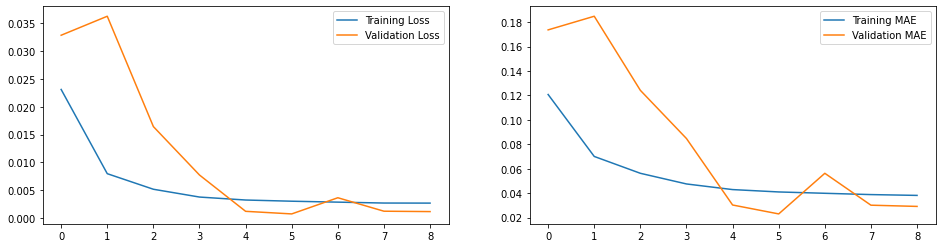

In [50]:
plot_graphs()

In [51]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [52]:
vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [60]:
df = df.set_index('Date')

In [61]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [62]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])
vis_df_c1 = pd.concat([a,b,c], axis=1)

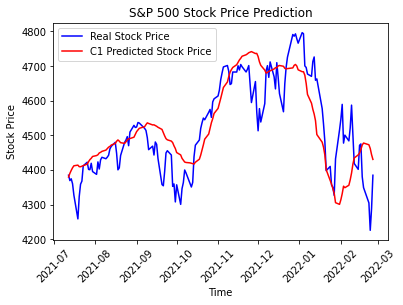

In [63]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'red', label = 'C1 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

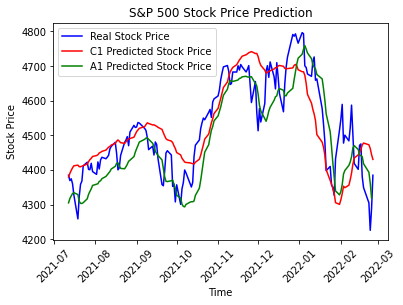

In [145]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'red', label = 'C1 Predicted Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment C.2

### Create the model

In [170]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(30,2), return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [171]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 20)            1840      
                                                                 
 dropout_1 (Dropout)         (None, 30, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 5,141
Trainable params: 5,141
Non-trainable params: 0
_________________________________________________________________


In [172]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [173]:
experiment = "ExperimentC2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [174]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 6s 74ms/step - loss: 0.0224 - mae: 0.1181 - val_loss: 0.0777 - val_mae: 0.2718
Epoch 2/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0071 - mae: 0.0667 - val_loss: 0.0201 - val_mae: 0.1374
Epoch 3/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0054 - mae: 0.0563 - val_loss: 0.0030 - val_mae: 0.0504
Epoch 4/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0055 - mae: 0.0544 - val_loss: 0.0063 - val_mae: 0.0754
Epoch 5/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0044 - mae: 0.0481 - val_loss: 0.0015 - val_mae: 0.0331
Epoch 6/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0043 - mae: 0.0471 - val_loss: 0.0029 - val_mae: 0.0490
Epoch 7/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0043 - mae: 0.0468 - val_loss: 0.0074 - val_mae: 0.0825
Epoch 8/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0034 - m

In [175]:
experiment = "ExperimentC2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [176]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

5/5 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0283
test set mae:  0.028283413499593735


### Plot performance

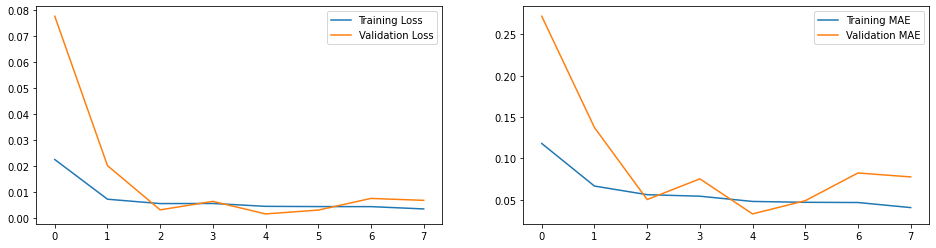

In [177]:
plot_graphs()

In [178]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [179]:
vis = scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [180]:
df = df.set_index('Date')

In [181]:
df1 = df.index.values
df1 = df1[train_size+val_size+time_step:]

In [182]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])
vis_df_c2 = pd.concat([a,b,c], axis=1)

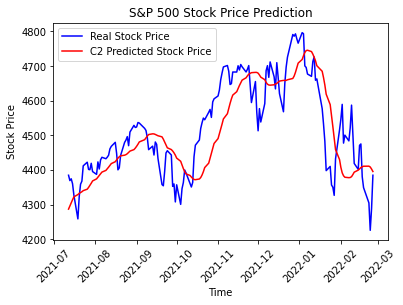

In [183]:
# plot baseline and predictions
plt.plot(vis_df_c2['Date'], vis_df_c2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'red', label = 'C2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

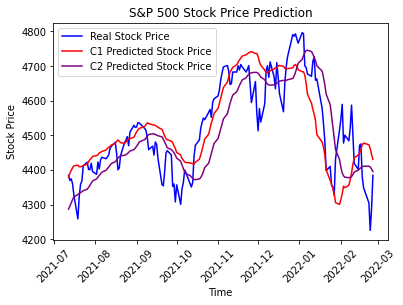

In [188]:
# plot baseline and predictions
plt.plot(vis_df_c2['Date'], vis_df_c2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'red', label = 'C1 Predicted Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'purple', label = 'C2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

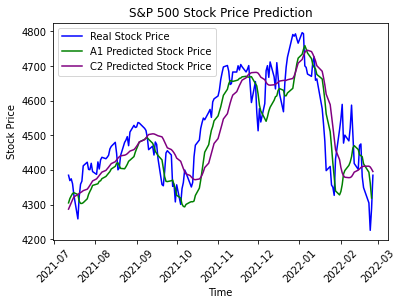

In [189]:
# plot baseline and predictions
plt.plot(vis_df_c2['Date'], vis_df_c2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'purple', label = 'C2 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Experiment D: Input - Closing Price and New Probable Cases, Time Step - 30, Dates filtered to existing COVID-19 cases

### Load Data

In [65]:
covid_df.head()

,submission_date,new_case,pnew_case
0,2021-01-01,227801,26295.0
1,2022-01-01,288614,36296.0
2,2021-01-02,226839,19715.0
3,2022-01-02,409050,59688.0
4,2021-01-03,205089,19598.0


In [73]:
df = df.reset_index()
df.head()

,Date,Close
0,2017-02-28,2363.639893
1,2017-03-01,2395.959961
2,2017-03-02,2381.919922
3,2017-03-03,2383.120117
4,2017-03-06,2375.310059


In [74]:
merge_df = pd.merge(df, covid_df, left_on = 'Date', right_on = 'submission_date', how = 'right')
merge_df.head()

,Date,Close,submission_date,new_case,pnew_case
0,NaT,NaN,2021-01-01,227801,26295.0
1,NaT,NaN,2022-01-01,288614,36296.0
2,NaT,NaN,2021-01-02,226839,19715.0
3,NaT,NaN,2022-01-02,409050,59688.0
4,NaT,NaN,2021-01-03,205089,19598.0


In [75]:
merge_df.isnull().sum()

Date               241
Close              241
submission_date      0
new_case             0
pnew_case            0
dtype: int64

The stock market is closed on weekends and holidays.

In [76]:
merge_df = merge_df[merge_df.Close.notna()]
merge_df = merge_df.drop(['submission_date'],axis=1)
merge_df.head()

,Date,Close,new_case,pnew_case
5,2022-01-03,4796.560059,928185,112344.0
6,2021-01-04,3700.649902,175329,26027.0
7,2022-01-04,4793.540039,734620,112674.0
8,2021-01-05,3726.860107,243649,39000.0
9,2022-01-05,4700.580078,714359,140254.0


In [77]:
merge_df.isnull().sum()

Date         0
Close        0
new_case     0
pnew_case    0
dtype: int64

### Explore Data

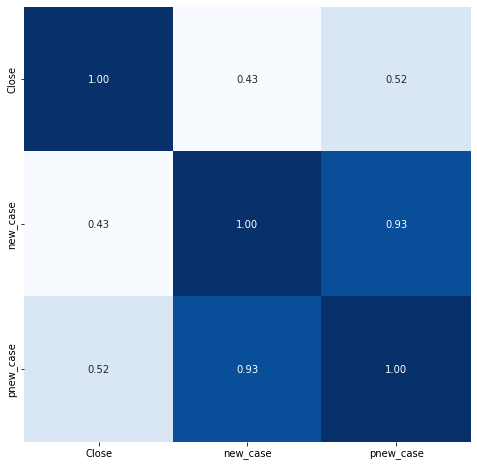

In [78]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(merge_df.corr(), annot=True, fmt='.2f', cbar=False, ax=ax, cmap='Blues')

The probable new cases have a smaller correlation compared to the confusion matrix seen in Experiment C.

In [79]:
merge_df = merge_df[['Date','Close','pnew_case']].sort_values(by='Date')

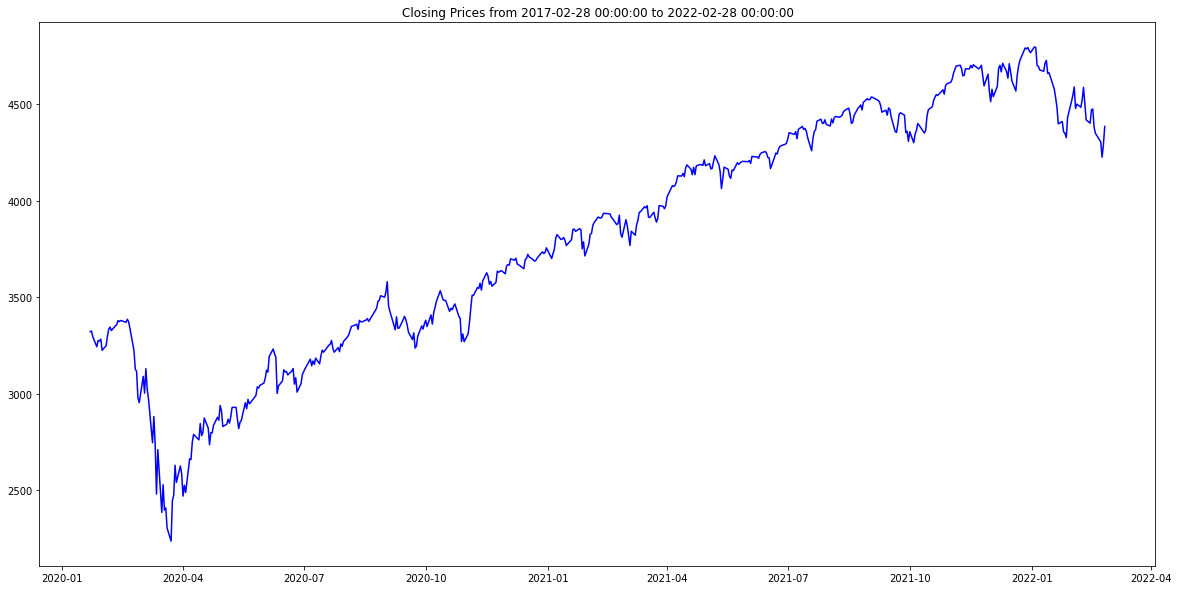

In [560]:
#dates where covid data was available 
start_date = datetime(2017, 2, 28)
end_date = datetime(2022, 2, 28)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(merge_df.Date, merge_df['Close'], color = 'blue')
#plt.plot(merge_df.Date, merge_df['pnew_case'], color = 'orange')
plt.show()

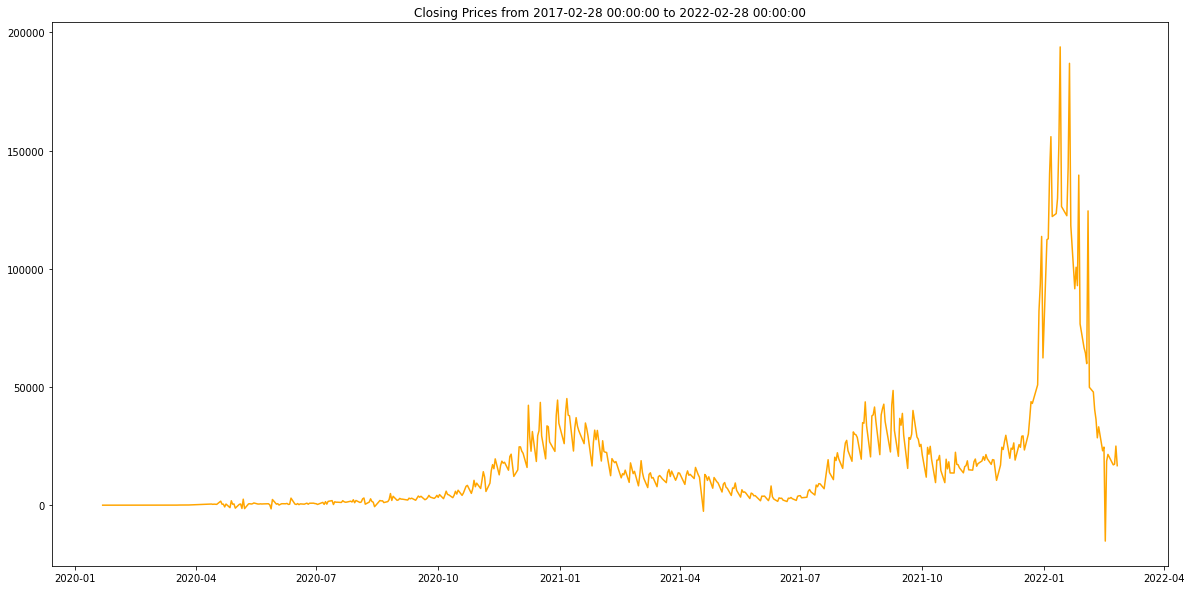

In [561]:
start_date = datetime(2017, 2, 28)
end_date = datetime(2022, 2, 28)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
#plt.plot(merge_df.Date, merge_df['Close'], color = 'blue')
plt.plot(merge_df.Date, merge_df['pnew_case'], color = 'orange')
plt.show()

### Preprocess Data

In [80]:
merge_df.set_index(keys='Date')

,Close,pnew_case
Date,,
2020-01-22,3321.750000,0.0
2020-01-23,3325.540039,0.0
2020-01-24,3295.469971,0.0
2020-01-27,3243.629883,0.0
2020-01-28,3276.239990,0.0
...,...,...
2022-02-18,4348.870117,21477.0
2022-02-22,4304.759766,17049.0
2022-02-23,4225.500000,17342.0


In [81]:
close_scaler = MinMaxScaler(feature_range=(0,1))
case_scaler = MinMaxScaler(feature_range=(0,1))
merge_data = merge_df.copy()
merge_data["Close"] = close_scaler.fit_transform(np.array(merge_df["Close"]).reshape(-1, 1))
merge_data["pnew_case"] = case_scaler.fit_transform(np.array(merge_df["pnew_case"]).reshape(-1, 1))

In [82]:
merge_data.shape

(530, 3)

In [83]:
# split into train, val, and test sets
train_size = int(len(merge_data) * 0.58)
val_size = int(0.22 * len(merge_data))
test_size = len(merge_data) - train_size - val_size

In [84]:
train_size, val_size, test_size

(307, 116, 107)

In [85]:
train_data,val_data, test_data = merge_data[0:train_size], merge_data[train_size:train_size+val_size], merge_data[train_size+val_size:len(merge_data)]

In [86]:
train_data.shape, val_data.shape, test_data.shape

((307, 3), (116, 3), (107, 3))

In [87]:
# choose a number of time steps
time_step = 30
input1 = "Close"
input2 = "pnew_case"

in_seq1, in_seq2, out_seq = input_sequence(train_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_train, y_train = split_sequences(dataset, time_step)
print(X_train.shape, X_train.shape)
for i in range(len(X_train)):
  print(X_train[i], y_train[i])
  break

(277, 30, 2) (277, 30, 2)
[[0.424 0.073]
 [0.425 0.073]
 [0.413 0.073]
 [0.393 0.073]
 [0.406 0.073]
 [0.405 0.073]
 [0.409 0.073]
 [0.386 0.073]
 [0.395 0.073]
 [0.414 0.073]
 [0.429 0.073]
 [0.433 0.073]
 [0.426 0.073]
 [0.436 0.073]
 [0.438 0.073]
 [0.446 0.073]
 [0.444 0.073]
 [0.447 0.073]
 [0.443 0.073]
 [0.449 0.073]
 [0.444 0.073]
 [0.43  0.073]
 [0.386 0.073]
 [0.348 0.073]
 [0.343 0.073]
 [0.29  0.073]
 [0.28  0.073]
 [0.333 0.073]
 [0.299 0.073]
 [0.349 0.073]] 0.3073430309320837


In [88]:
in_seq1, in_seq2, out_seq = input_sequence(val_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_val, y_val = split_sequences(dataset, time_step)

In [89]:
in_seq1, in_seq2, out_seq = input_sequence(test_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_test, y_test = split_sequences(dataset, time_step)

In [90]:
X_train.shape, X_val.shape, X_test.shape

((277, 30, 2), (86, 30, 2), (77, 30, 2))

## Experiment D.1

### Create the model

In [587]:
model = models.Sequential()
model.add(LSTM(20, input_shape=(30, 2))) 
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [588]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 20)                1840      
                                                                 
 dropout_43 (Dropout)        (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


In [589]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [590]:
experiment = "ExperimentD1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [591]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
9/9 [==============================] - 4s 125ms/step - loss: 0.0910 - mae: 0.2537 - val_loss: 0.0800 - val_mae: 0.2812
Epoch 2/50
9/9 [==============================] - 0s 43ms/step - loss: 0.0341 - mae: 0.1418 - val_loss: 0.0053 - val_mae: 0.0697
Epoch 3/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0314 - mae: 0.1434 - val_loss: 0.0070 - val_mae: 0.0810
Epoch 4/50
9/9 [==============================] - 0s 27ms/step - loss: 0.0218 - mae: 0.1164 - val_loss: 0.0165 - val_mae: 0.1266
Epoch 5/50
9/9 [==============================] - 0s 31ms/step - loss: 0.0238 - mae: 0.1193 - val_loss: 0.0120 - val_mae: 0.1074
CPU times: user 4.6 s, sys: 84 ms, total: 4.69 s
Wall time: 5.08 s


In [91]:
experiment = "ExperimentD1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [593]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

3/3 [==============================] - 1s 8ms/step - loss: 0.0204 - mae: 0.1355
test set mae:  0.13550519943237305


### Plot performance

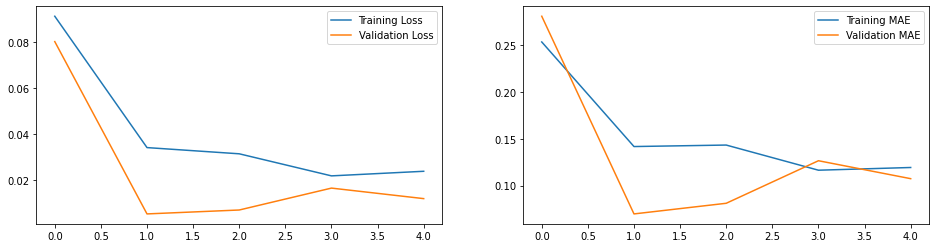

In [594]:
plot_graphs()

In [92]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [93]:
merge_data_vis = merge_data.copy()
close_data = np.array(merge_data_vis['Close']).reshape(-1,1)
vis = scaler.inverse_transform(close_data)
vis = vis[train_size+val_size+time_step:len(close_data)]

In [94]:
merge_data_vis = merge_data_vis.Date
merge_data_vis = merge_data_vis[train_size+val_size+time_step:]

In [95]:
a = pd.DataFrame(merge_data_vis, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])
vis_df_d1 = pd.concat([a,b,c], axis=1).sort_values(by='Date')

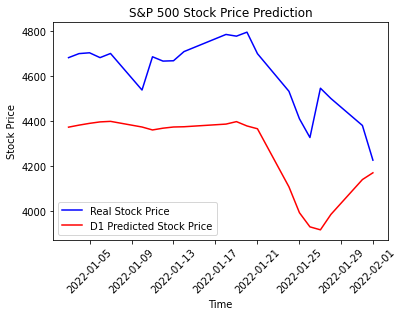

In [97]:
# plot baseline and predictions
plt.plot(vis_df_d1['Date'], vis_df_d1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'red', label = 'D1 Predicted Stock Price')

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()